# Homework 3 Cibersecurity
* Sebastián Navarro 00321588
* Eduardo Guerrero 00326712
* Mateo Pozo 00320780

## Part 1: picoCTF

### Local Authority

For this exercise, we are asked to launch an on-demand instance. Once the instance is launched, we are given a link to a webpage at [http://saturn.picoctf.net:58461/](http://saturn.picoctf.net:58461/). The hint for the exercise suggests finding the way the password is verified on the webpage.

When accessing the link, a webpage appears asking for a username and password, as shown below:

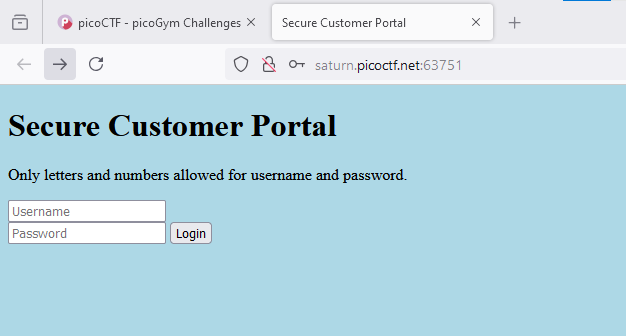

If we try any username and password, an error message appears indicating that the password is incorrect. However, one way to find out how the password is being verified is to inspect the webpage's source code.

To do this, we can use the developer options of our browser. In this case, we use the "network" tool to see the requests being made to the server. This is where all the requests the webpage makes to the server are shown, including images, CSS files, scripts, and HTTP requests like POST.

Therefore, we try any username and password and observe the requests made to the server.

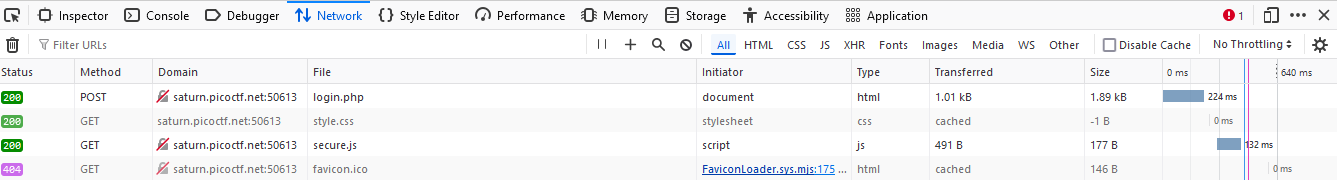

We can see in the image that a POST request is made to `login.php`. When reviewing the source code of `login.php`, we notice that a JavaScript script called `secure.js` is executed.

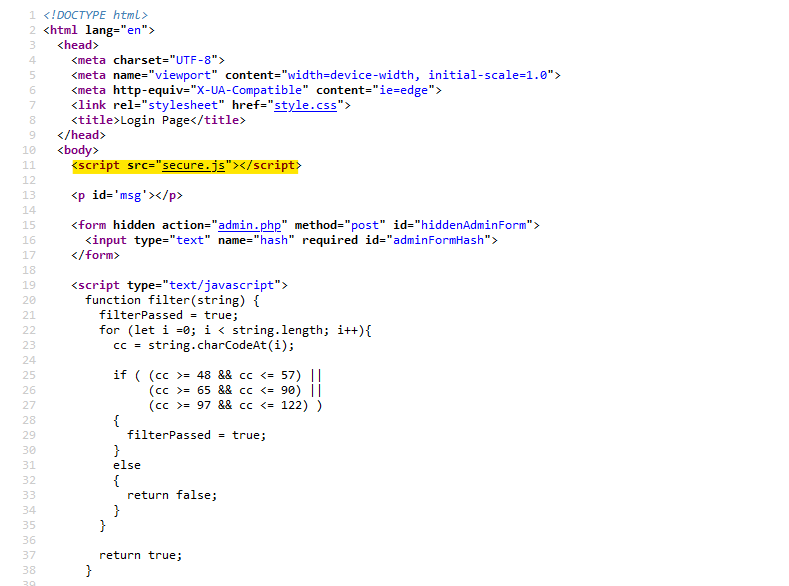

This JavaScript code is responsible for verifying if the entered password is correct. By reviewing the code, we see that the password is checked using the `checkPassword` function, which takes the username and the entered password as arguments.

```javascript
function checkPassword(username, password)
{
  if( username === 'admin' && password === 'strongPassword098765' )
  {
    return true;
  }
  else
  {
    return false;
  }
}
```

Therefore, the correct username is 'admin' and the correct password is 'strongPassword098765'. When we enter this information, the flag for the exercise appears.

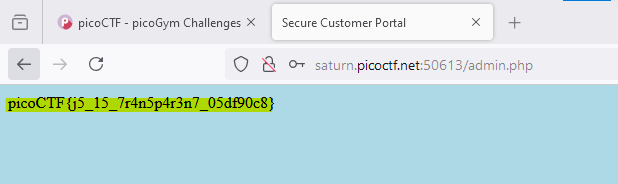

The flag for the exercise is `picoCTF{j5_15_7r4n5p4r3n7_05df90c8}`.

### WebDecode

From the name of the exercise, we can infer that this is a decoding problem. Like the previous exercise, we are required to launch an instance of on-demand. Once launched, we are given a link to a web page at http://titan.picoctf.net:51601/.

When we access the link, we are presented with a web page like this:

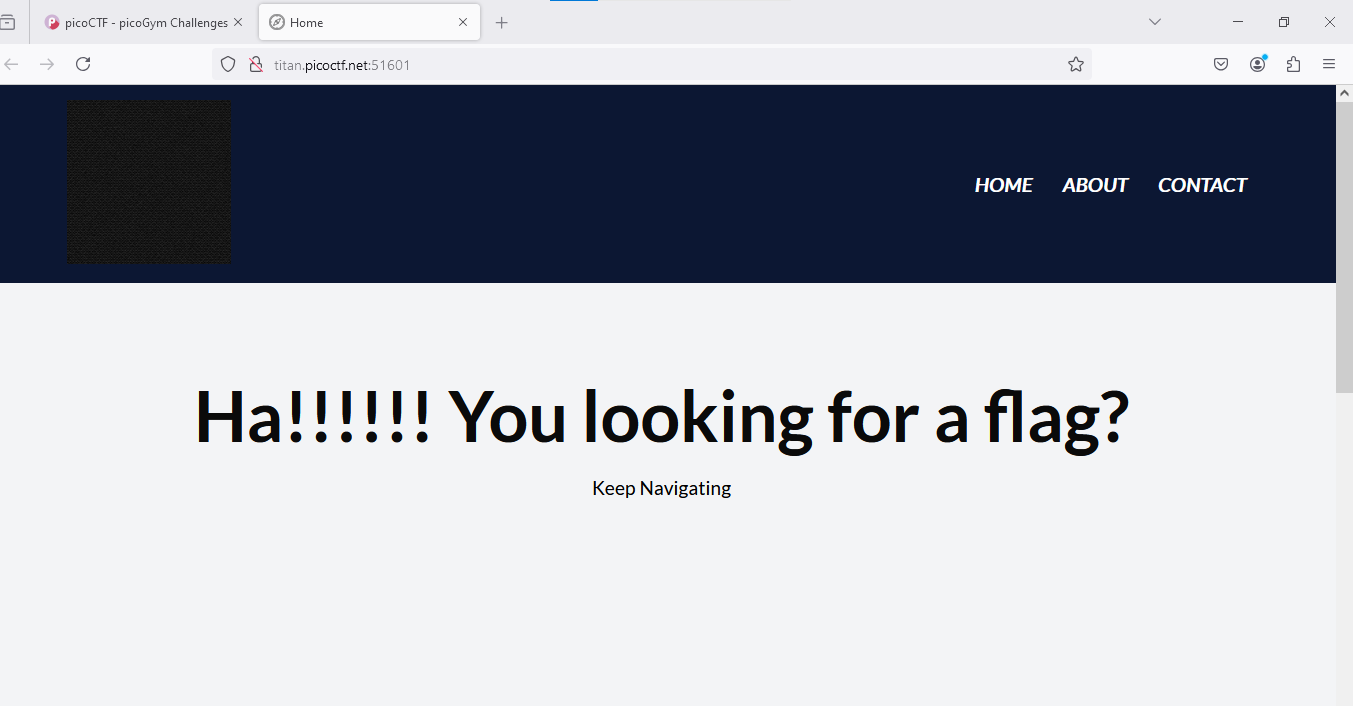

The other clue suggests that we inspect the source code of the web page. When doing so, in the `About` section, we find a text that appears to be encoded, as follows:

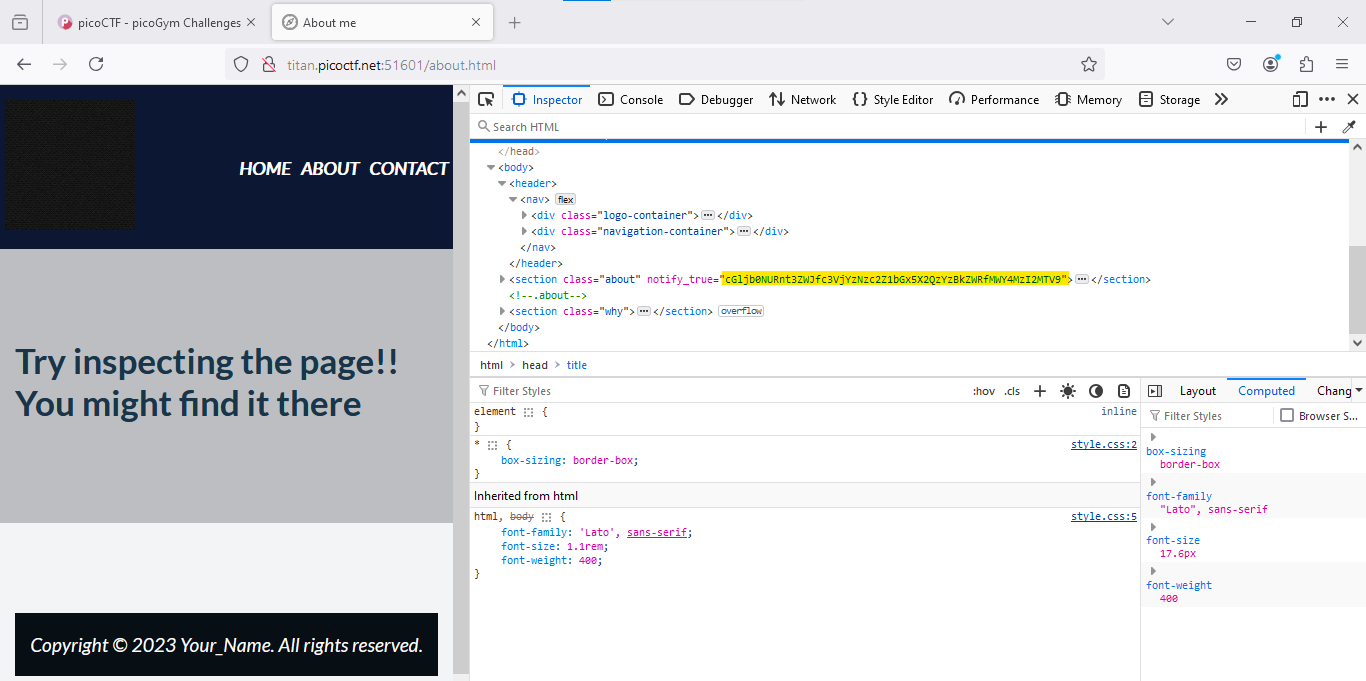

The encoded text is `cGljb0NURnt3ZWJfc3VjYzNzc2Z1bGx5X2QzYzBkZWRfMWY4MzI2MTV9`, which appears to be a base64 encoded text since it contains alphanumeric characters and also has a length of 56, which is a multiple of 4. To decode it, we can use Python's `base64` library to find the flag.

In [2]:
import base64

encoded_text = "cGljb0NURnt3ZWJfc3VjYzNzc2Z1bGx5X2QzYzBkZWRfMWY4MzI2MTV9"

decoded_string = base64.b64decode(encoded_text).decode('utf-8')
print(decoded_string)

picoCTF{web_succ3ssfully_d3c0ded_1f832615}


The flag for the exercise is `picoCTF{web_succ3ssfully_d3c0ded_1f832615}`.

### More SQLi

Based on the name of the exercise and the hint, we can infer that this is an SQL injection problem with SQLite. Like the previous exercises, we are asked to launch an on-demand instance. Once launched, we are given a link to a webpage at http://saturn.picoctf.net:58685/ and we are presented with a webpage to enter a username and password, as shown below:

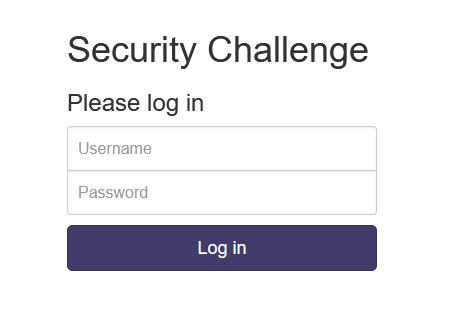

When testing any username and password, the following screen appears:

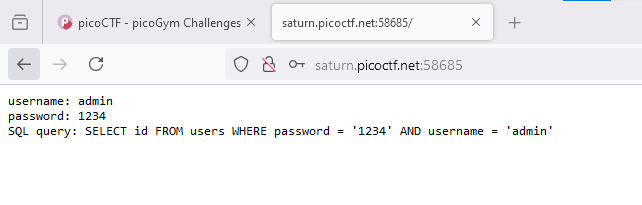

This clearly shows the SQL query being executed on the server, which is as follows:

```sql
SELECT id FROM users WHERE password = '1234' AND username = 'admin'
```

This SQL statement tells us that the `id` is being selected from the `users` table where a matching password and username are required, both of which we do not know. Therefore, to successfully log in, we can attempt to inject an SQL statement that is always true. To do this, we can enter `' OR 1=1 --` in the password field. By doing this, the SQL statement that is executed on the server becomes:

```sql
SELECT id FROM users WHERE password = '' OR 1=1 --' AND username = 'admin'
```

This way, the `OR` condition validates a condition that is always true, such as `1 = 1`, and the password verification is skipped by commenting it out with the `--`. The `OR` condition returns true if at least one of the conditions is true, so by injecting this SQL statement, we successfully log in.

Once logged in, we see the following table:

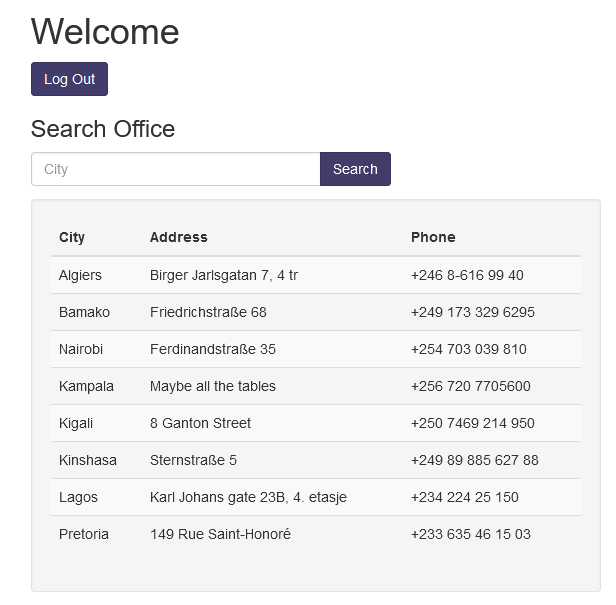

We can assume that the search button executes an SQL query to search for the city that matches the entered text. For example, if we enter 'Algiers', the SQL query executed on the server is as follows (assuming the table is named `cities`):

```sql
SELECT city, address, phone FROM cities WHERE city = 'Algiers'
```

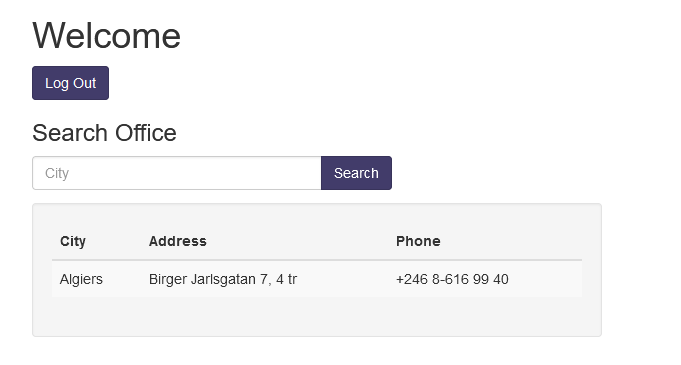

For more information, we want to obtain the table names from the database through SQL injection. To do this, we can enter `' UNION SELECT name,2,3 FROM sqlite_master WHERE type='table' --` in the search field. By doing this, the SQL statement executed on the server becomes (assuming the table is named `cities`):

```sql
SELECT city, address, phone FROM cities WHERE city = '' UNION SELECT name,2,3 FROM sqlite_master WHERE type='table' -- 
```

We use the `UNION` to join with the `sqlite_master` table to obtain the names of the tables in the SQLite database. We use `2` and `3` to match the number of columns in the table displayed.

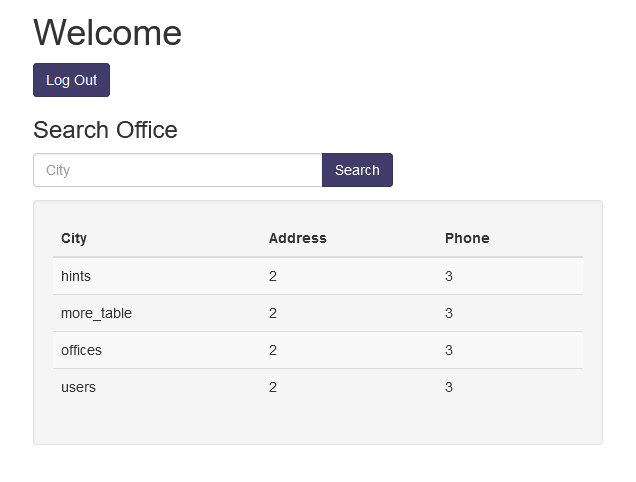

We see that this statement shows the tables in the database: `hints`, `more_table`, `offices`, `users`.

Now, we want to obtain the column names for each table in the database. To do this, for the `users` table, we can enter `' UNION SELECT name,2,3 FROM PRAGMA_table_info('users') --` in the search field. By doing this, the SQL statement executed on the server becomes (now we know that the table shown is `offices`):

```sql
SELECT city, address, phone FROM offices WHERE city = '' UNION SELECT name,2,3 FROM PRAGMA_table_info('users') --
```

We use the `UNION` with `PRAGMA_table_info('users')` to get the column names of the `users` table.

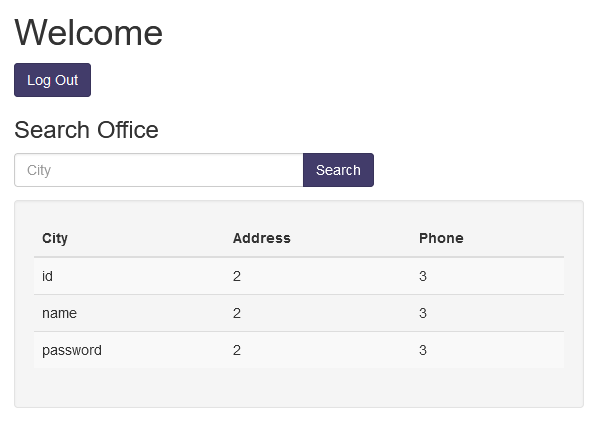

We do the same for the `offices` table and get the column names of the `offices` table:

```sql
SELECT city, address, phone FROM offices WHERE city = '' UNION SELECT name,2,3 FROM PRAGMA_table_info('offices') --
```

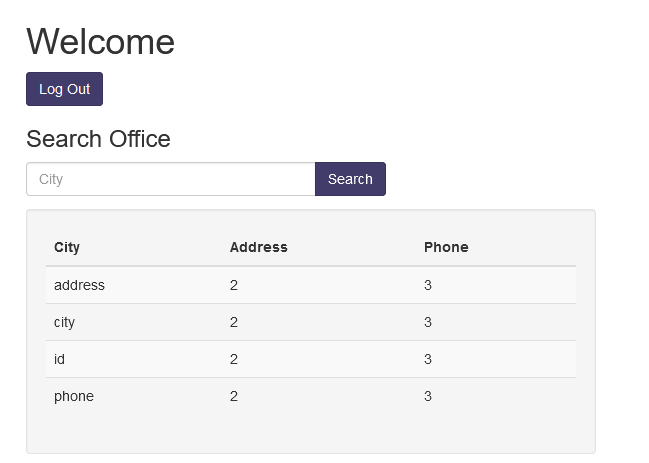

We do the same for the `hints` table and get the column names of the `hints` table:

```sql
SELECT city, address, phone FROM offices WHERE city = '' UNION SELECT name,2,3 FROM PRAGMA_table_info('hints') --
```

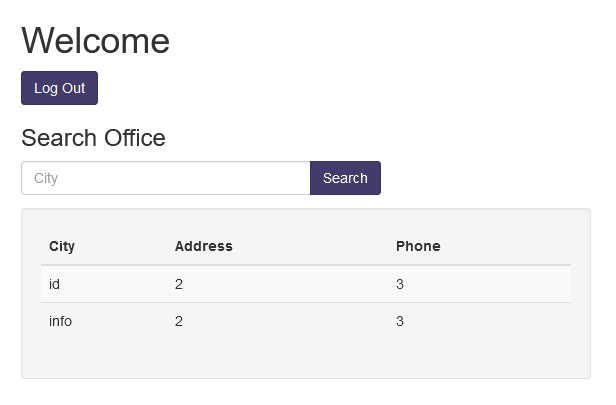

We do the same for the `more_table` table and get the column names of the `more_table` table:

```sql
SELECT city, address, phone FROM offices WHERE city = '' UNION SELECT name,2,3 FROM PRAGMA_table_info('more_table') --
```

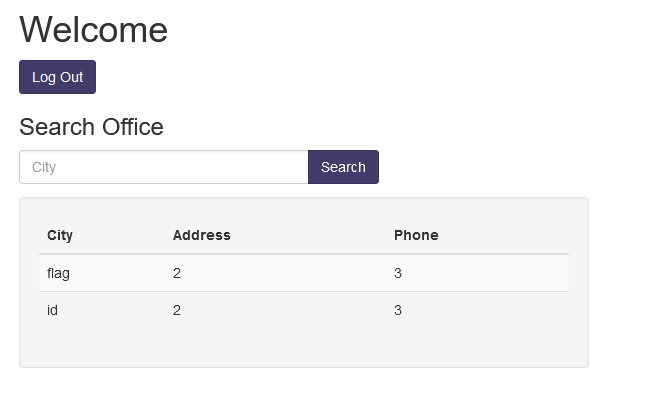

In this way, we have obtained the names of the tables and columns from the database. In summary:
* Tables: `hints`, `more_table`, `offices`, `users`
* Columns of the `users` table: `id`, `name`, `password`
* Columns of the `offices` table: `id`, `city`, `address`, `phone`
* Columns of the `hints` table: `id`, `info`
* Columns of the `more_table` table: `id`, `flag`

We see that the `more_table` table has a column called `flag`, so we can assume that the flag for the exercise is stored in this table. To get the flag, we can enter `' UNION SELECT flag,2,3 FROM more_table --` in the search field. By doing this, the SQL statement executed on the server becomes:

```sql
SELECT city, address, phone FROM offices WHERE city = '' UNION SELECT flag,2,3 FROM more_table -- 
```

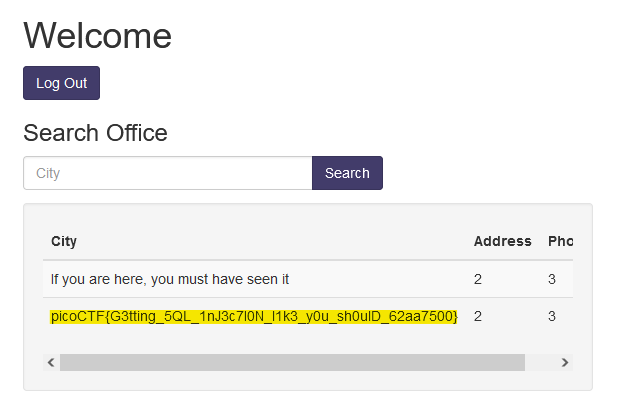

The flag for the exercise is `picoCTF{G3tting_5QL_1nJ3c7I0N_l1k3_y0u_sh0ulD_62aa7500}`.

#### Provide an explanation of which OWASP Top 10 was exploited

In this exercise, the **Injection vulnerability** from OWASP, specifically **SQL Injection**, was exploited, which ranks number 3 in the OWASP Top 10. This vulnerability occurs when an attacker inserts or "injects" SQL code into the input fields of a web form to gain access to the underlying database. In this case, the attacker took advantage of the lack of input validation in the username and password fields to inject malicious SQL code, allowing them to bypass authentication (using an injection like `' OR 1=1 --`) and access the database. Then, by using additional SQL injections, the attacker retrieved the table and column names, and finally extracted the **flag** from the `more_table` table. This demonstrates how the lack of input sanitization allows SQL queries to be manipulated, leading to unauthorized access to sensitive data.

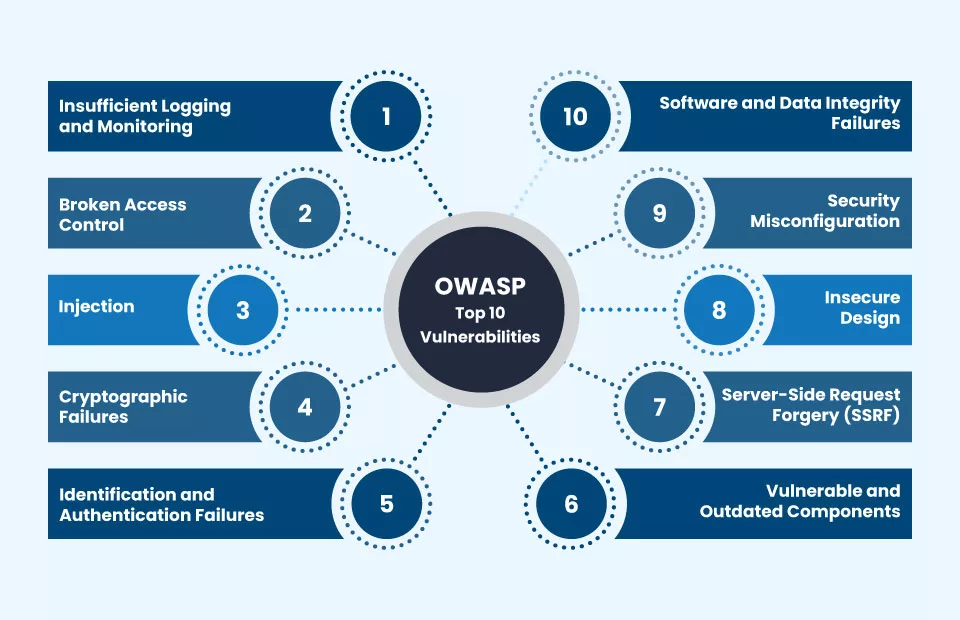

#### What would be a way to patch the vulnerability?

To patch the vulnerability, the application should use **parameterized queries** or prepared statements to prevent SQL injection attacks. This technique separates the SQL query from the user input, ensuring that the input is treated as data and not as part of the SQL query. By using parameterized queries, the database engine can distinguish between the SQL code and the user input, preventing the injection of malicious code. Additionally, the application should validate and sanitize user input to ensure that it meets the expected format and does not contain any malicious code. By implementing these security measures, the application can protect against SQL injection attacks and prevent unauthorized access to the database.

For example, the application could use the following parameterized query to validate the username and password:

```sql
SELECT id FROM users WHERE password = ? AND username = ?
```

By using placeholders (`?`) for the user input, the application can pass the input as parameters to the query, preventing SQL injection attacks. This approach ensures that the input is treated as data and not as part of the SQL query, protecting against malicious code injection.

## Part 2: WAF

A web application firewall is a layer 7 defense mechanism that helps protect web apps 
by filtering and monitoring HTTP traffic between the server and the clients. This mechanism
protects applications from common attacks like cross-side scripting, file inclusion, SQL 
injections, among others. 

By deploying a WAF in front of our web application, a defense mechanism is placed between
the web application and the internet. In this way, the WAF works as a reverse proxy that protects the server from direct exposure by having clients go thorugh the WAF before reaching the server. 

### Deploying DVWA in Azure

First, we deploy the instance of dvwa without the WAF. For this, we have to first create a resource group in Azure, to which we are going to upload our dvwa docker image `vulnerables/web-dvwa`.

To create the resource group, we use Azure CLI:

``` bash
az group create --name csdvwa --location eastus
```

After the resource group is created, we have to create an Azure Container Registry within our resource group to which we are going to push our Docker image. 

On our machine, run the following commands: 

```bash
az login

az acr login --name myregisto

docker pull vulnerables/web-vwa

docker tag vulnerables/web-dvwa myregistro.azurecr.io/vulnerables/we-dvwa

docker push myregistro.azurecr.io/vulnerables/web-dvwa
```
```

To check if our docker image was succesfully pushed to the ACR, we run the following command in our terminal.

```bash
az acr repository list --name myregistro --output table
```

Now, back in the Azure CLI, we can create the container within our resource group.

```bash
# Generate a unique name for the container
DNS_NAME_LABEL=DVWA-$RANDO

# Create the container from the ACR
az container create \
  --resource-group csdvwa \
  --name dvwa \
  --image myregistro.azurecr.io/vulnerables/web-dvwa \
  --ports 80 \
  --dns-name-label $DNS_NAME_LABEL \
  --location eastus \ 
```

To see the created container details, and to start it we run:

```bash
# See the container details
az container show \
  --resource-groupcsdvwaC \
  --name dv

# Start the container
az container start \
  --resource-groupcsdvwaC \
  --name dvwawa
```

Now the application is deployed; however, it is vulnerable to all the kinds of attacks it was designed to receive. For example, a SQL injection:

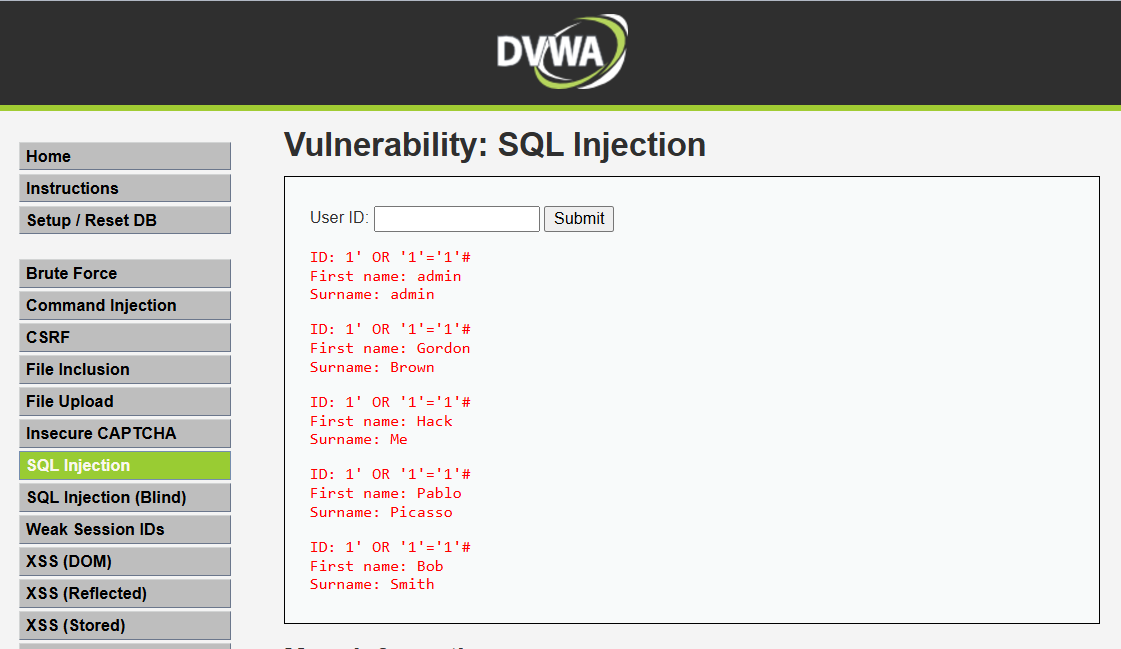

### The Azure Web Application Firewall

In this work, we apply the Azure Web Application Firewall (WAF). Azure WAF is a cloud-scale security add-on for securing web applications against their most prevalent attacks including SQL injection, cross-site scripting (XSS) and DDoS. It operates by filtering and monitoring HTTP(S) requests, blocking malicious traffic based on customizable rules and predefined security policies. Among its features are real-time threat intelligence, in-built defense using components of Azure services, and coverage of OWASP top-10 vulnerabilities. By taking advantage of Azure WAF this work aims to prevent attacks on the DVWA we are testing.

The Azure WAF operates in primarily two modes: detection and prevention. In Detection mode, the WAF maintains a log of both the incoming and outgoing traffic and records requests that are filtered according to its rule base, but does not actively deny them. This mode has the benefit of the ability to determine how WAF rules affect application traffic, and find possible threats without affecting the user experience. Whilst in Prevention mode the WAF actively blocks any comms fulfilling its security rules, thereby preventing access to possibly malicious traffic to the app. This mode provides real-time protection by automatically enforcing security policies and mitigating attacks, ensuring that only legitimate requests are processed. Both modes are configurable with custom rules to meet the security requirements, offering flexibility and control on application security.

### Setting up the WAF

To deploy a web application with WAF enabled, we need to set up several resources. All of these should be installed within the same group of resources of the web application (csdvwa). 

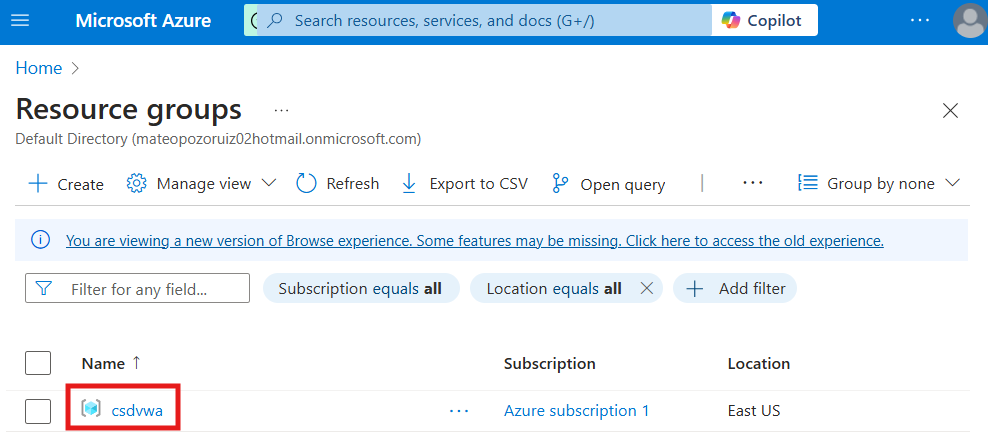

#### Container Instance: waf-dvwa

Since the traffic directed to the dvwa won't directly reach it, we need to set up this container with a configuration so that traffic always passes through the firewall first. 

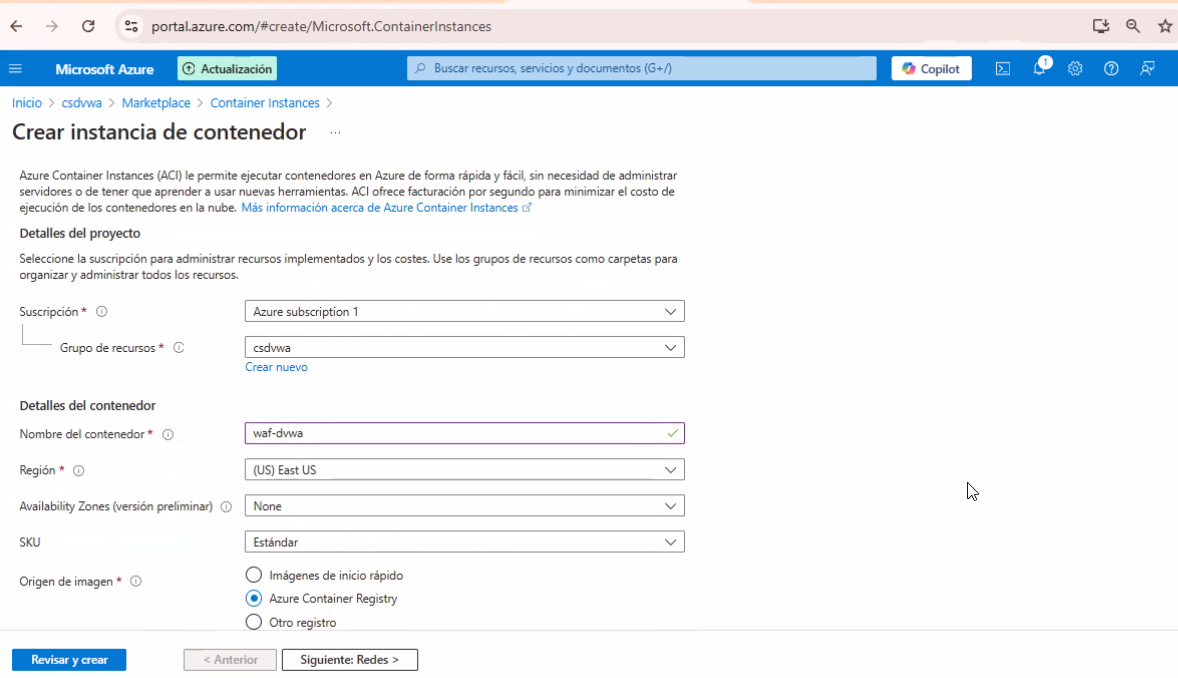

#### Virtual network: csdvwa-vnet 

The configuration from this container will be different, we need to create a virtual network (csdvwa-vnet).  

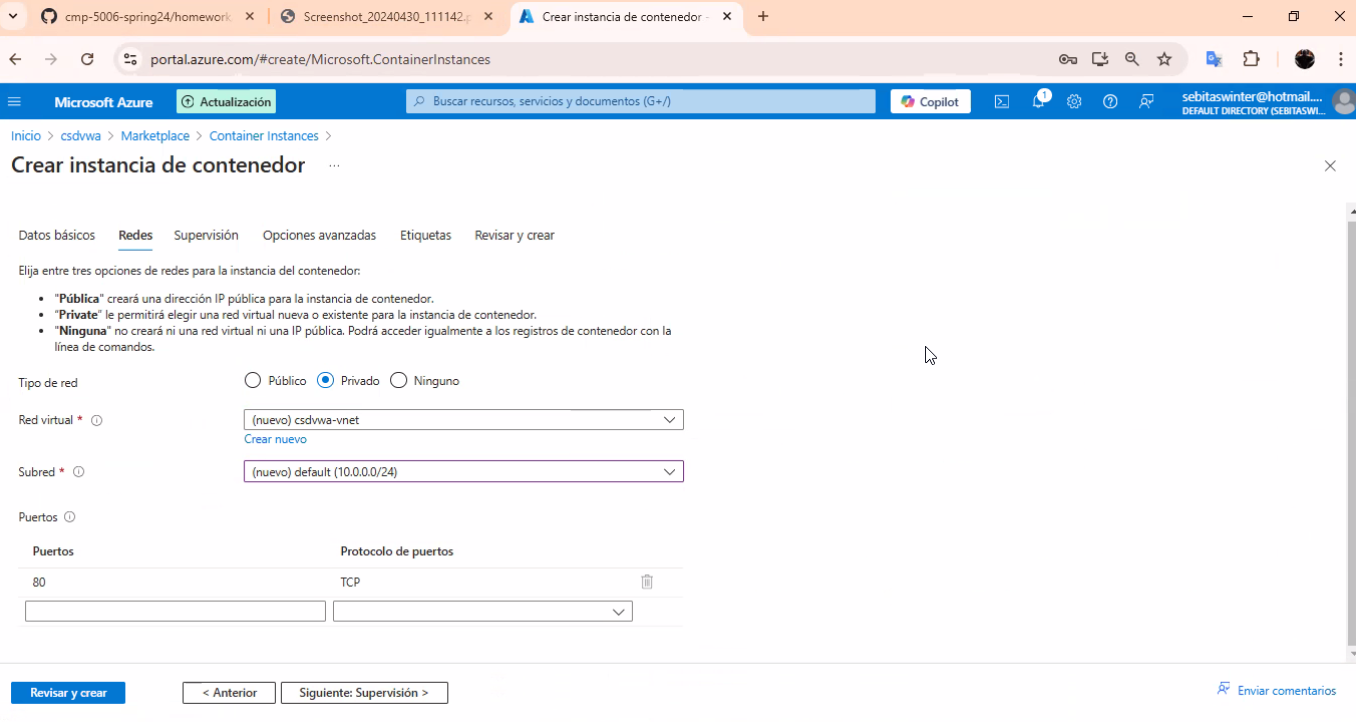

This vnet will be configured with the defaults:

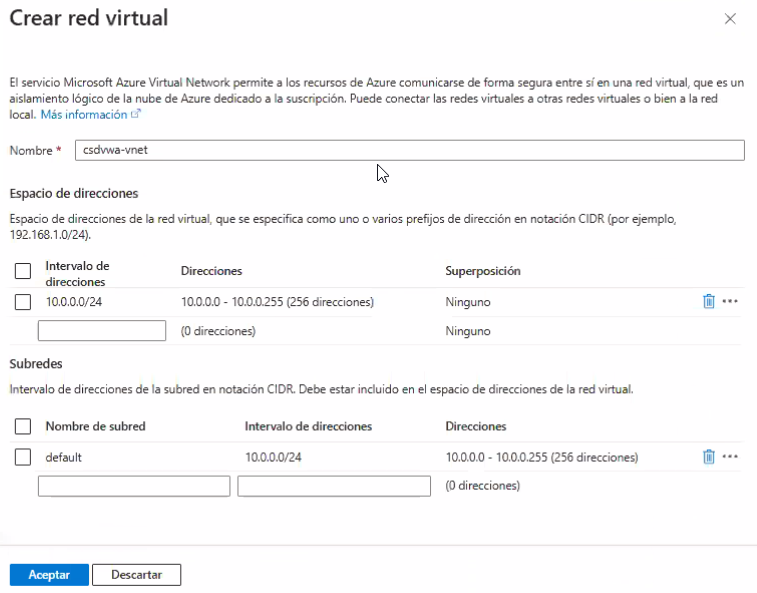

#### Log Analytics workspace

The Log Analytics workspace will enable centralized storage and management of logs from both the Application Gateway and the Web Application Firewall (WAF). This setup will provide comprehensive visibility into network traffic, including connection details and potential security threats. By aggregating these logs, we can efficiently monitor, analyze, and detect anomalous behavior, facilitating quick identification and response to potential attacks or suspicious activities.

To create the Log Analytics workspace, we need to name it and use the default configurations: 

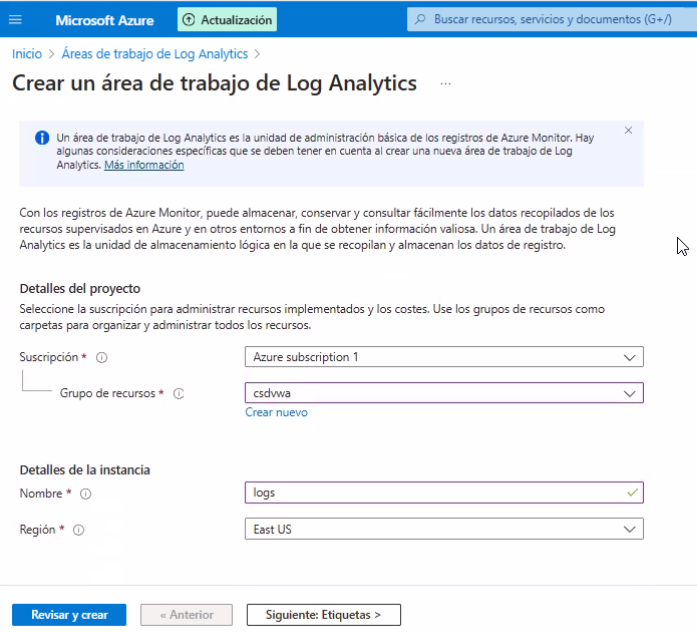

#### Application Gateway

Azure Web Application Firewall (WAF) needs to be associated with an Application Gateway because the gateway acts as a Layer 7 load balancer that manages and routes incoming web traffic to backend services. 

To create the application gateway, we follow the configuration below:

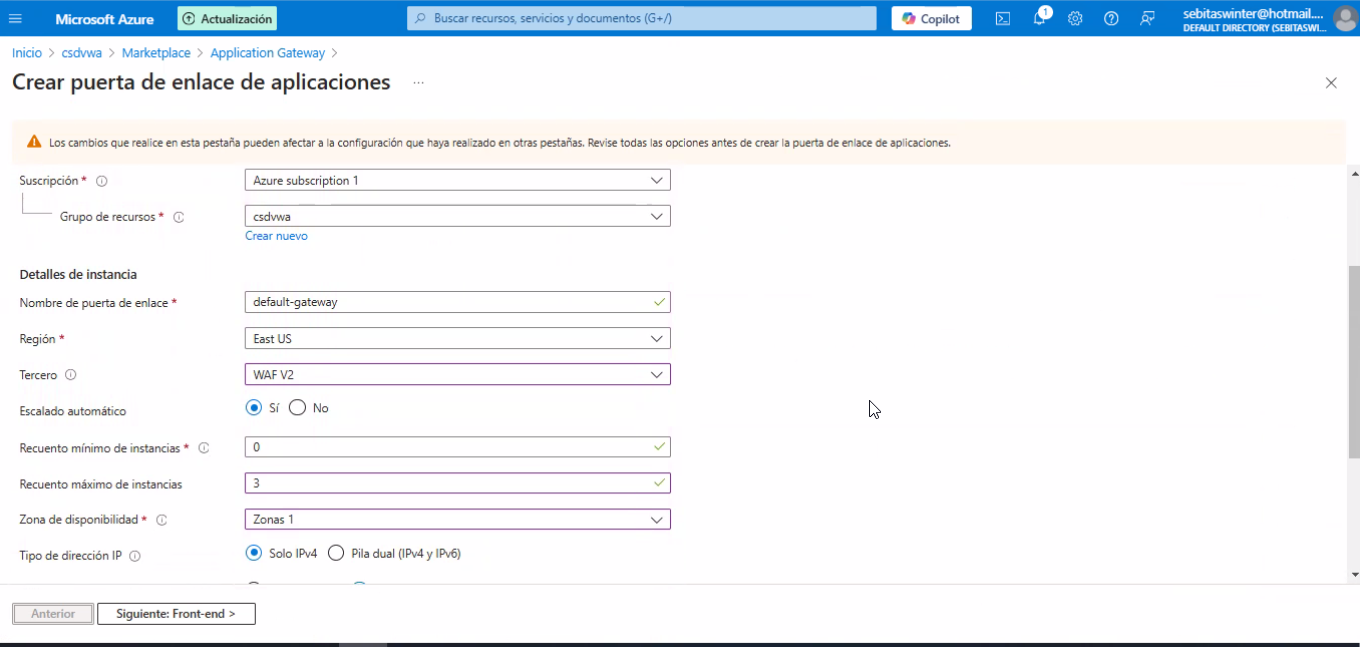

**Application Gateway WAF policy**

The WAF policy will protect the application from many common web attacks, including those listed in the OWASP to 10 threats. We set this policy up in the gateway configutation:

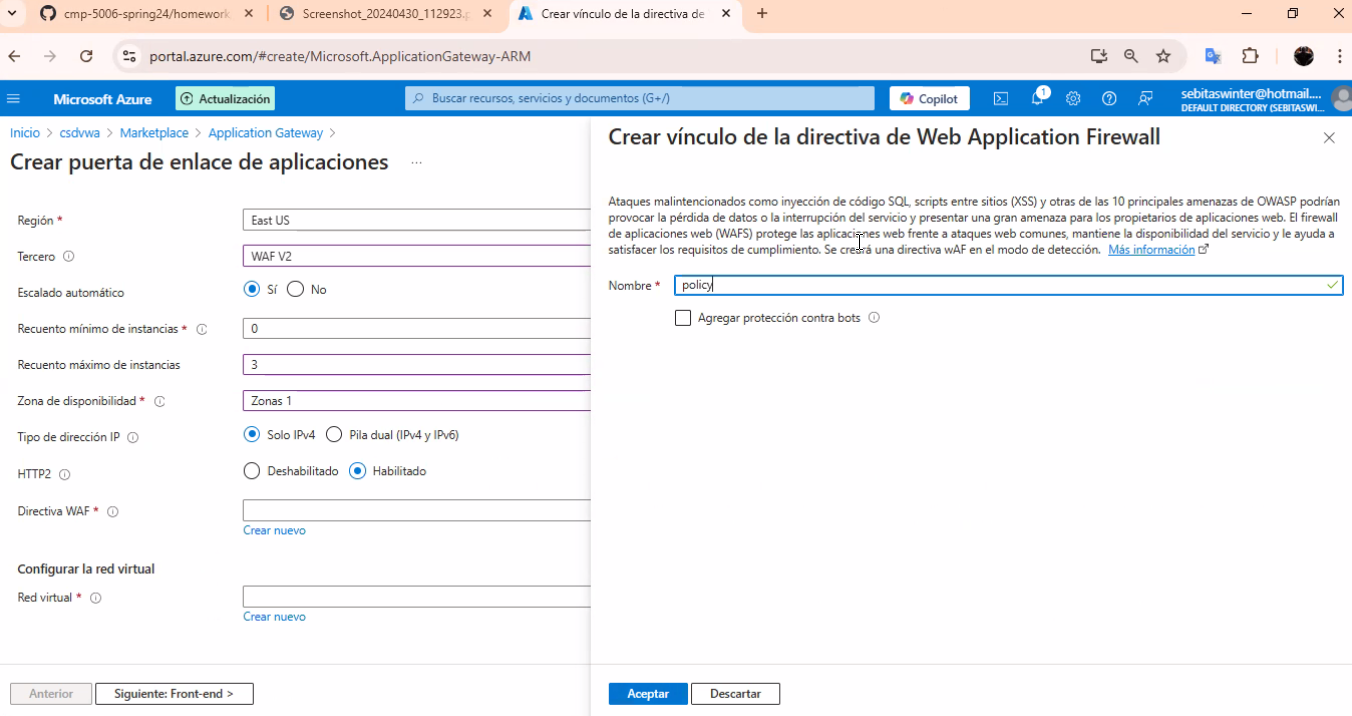

#### Virtual network: waf-vnet

We need to create another vnet for the Application Gateway. The application gateway and the dvwa container will be connected later.

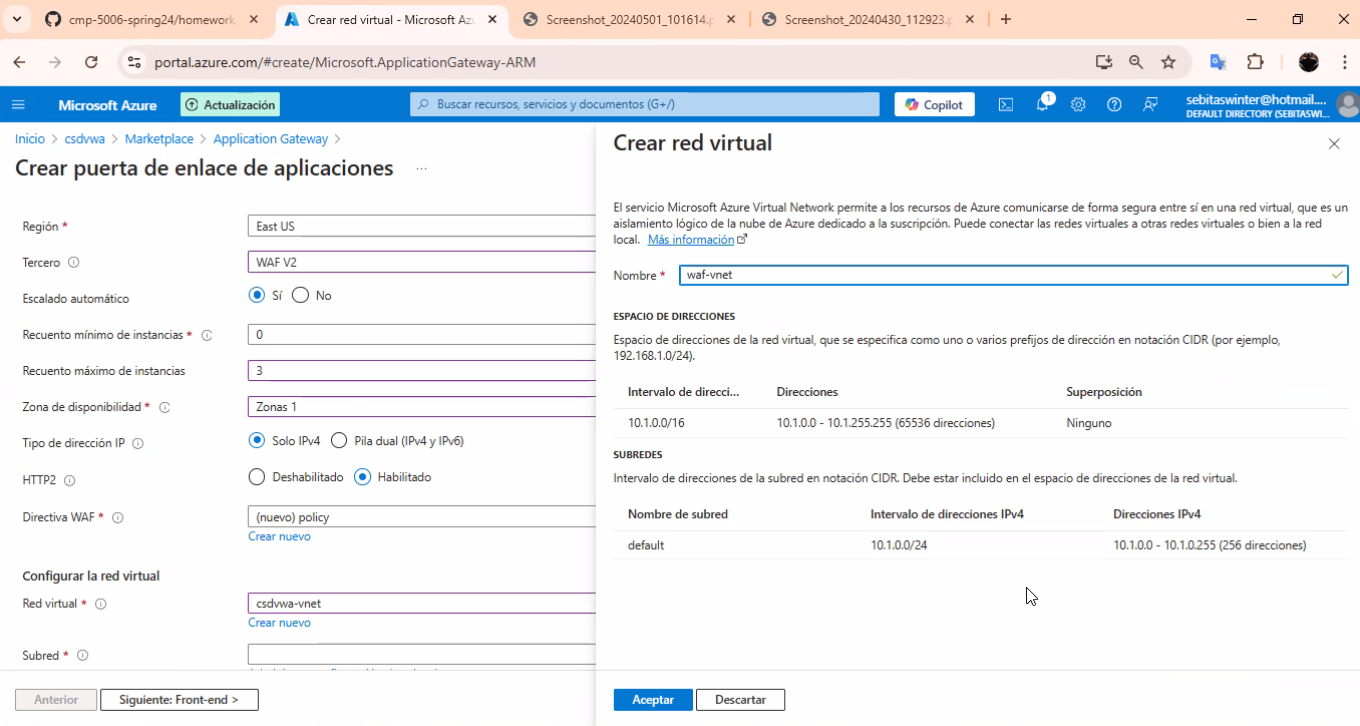

#### Public IP Address

To configure the gateway, we need to create a public IP address to which the users will connect to the application passing through the WAF. We name this IP address `secure-dvwa`. To create it, we just name it in the front-end configuration of the Application Gateway, and keep the defaults.

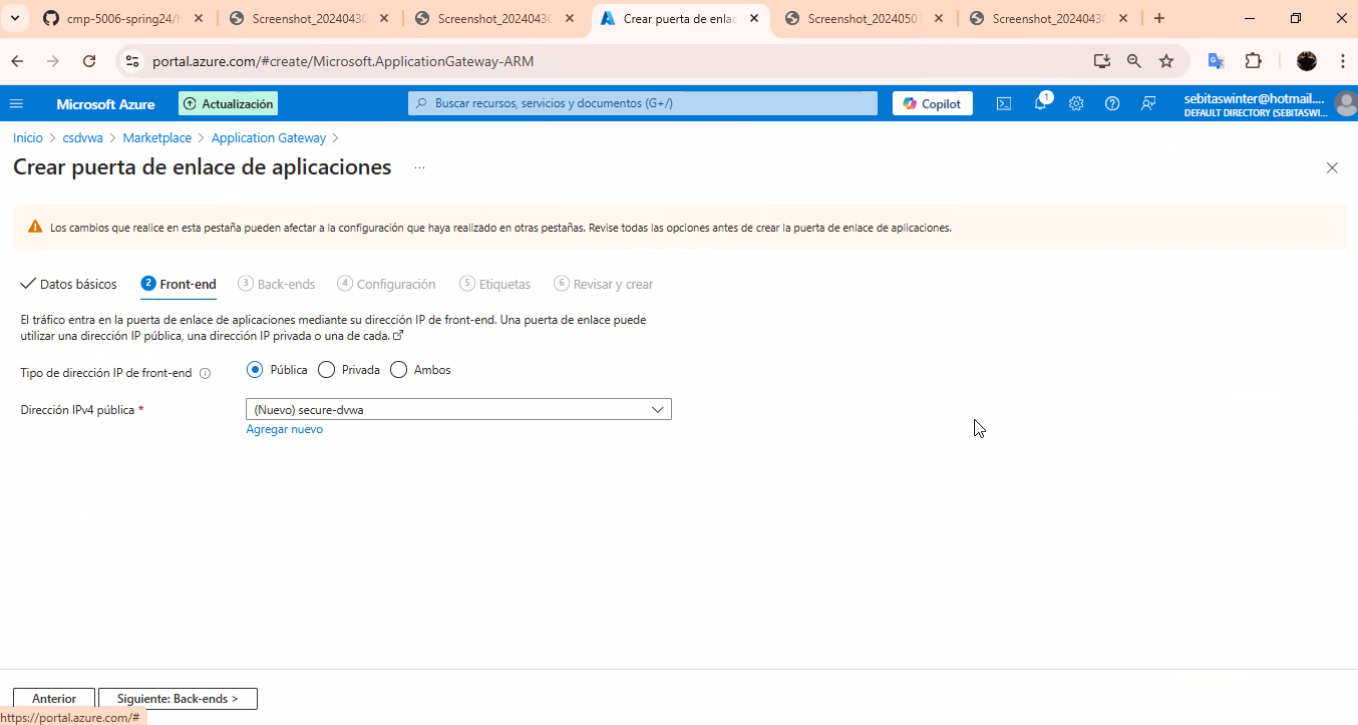

#### Back-end pools

Inside the Application Gateway configuration, we add a backend pool without targets. This is named `secure-dvwa-pool`, and the secure-dvwa instance container will be added to this pool, so that the Application Gateway redirects the traffic to it. 

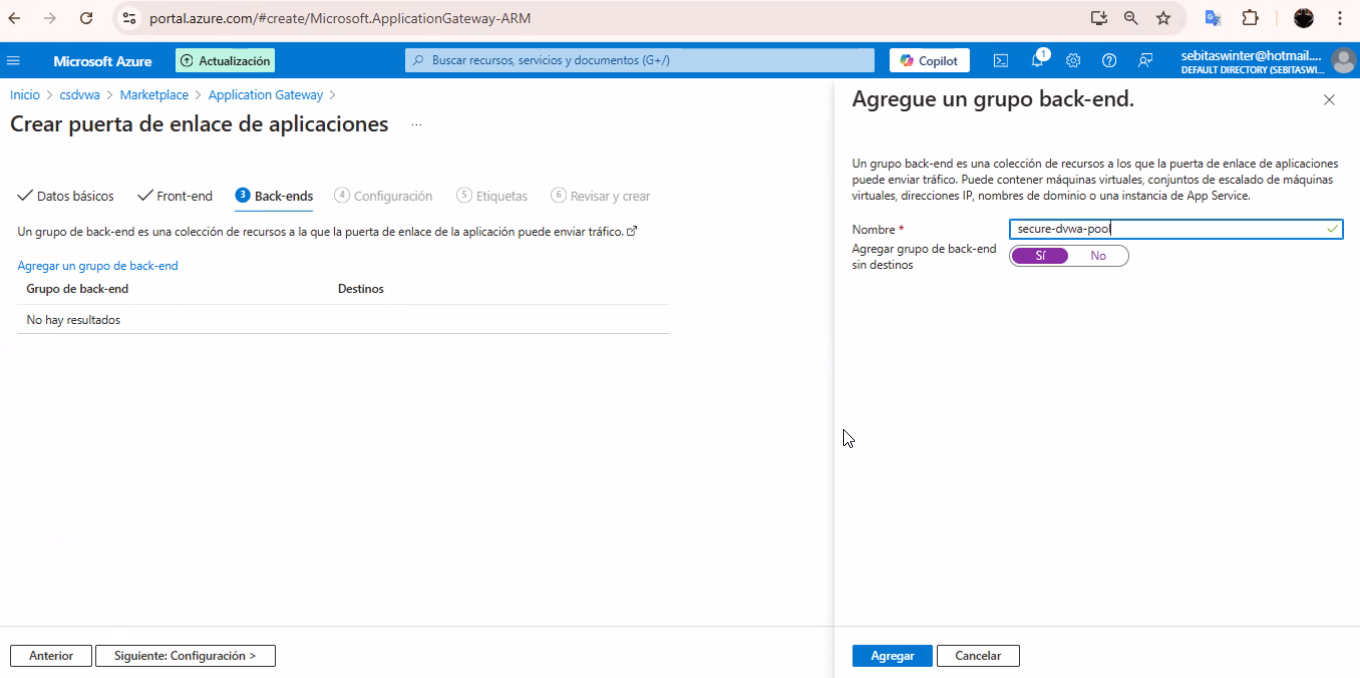

#### Routing rules

Now we need to add the routing rules for our configuration. For this, we use the default configurations; we just need to name the routing rule name `waf-route-rule`.

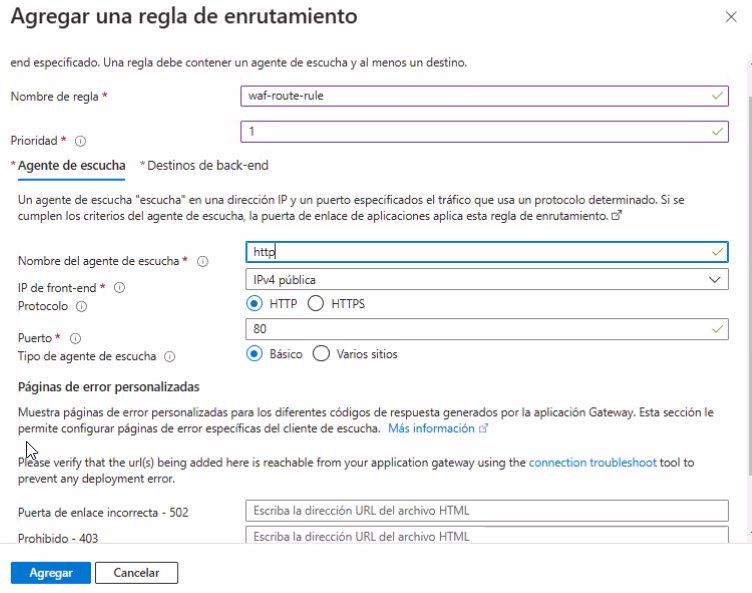

For the listener: 

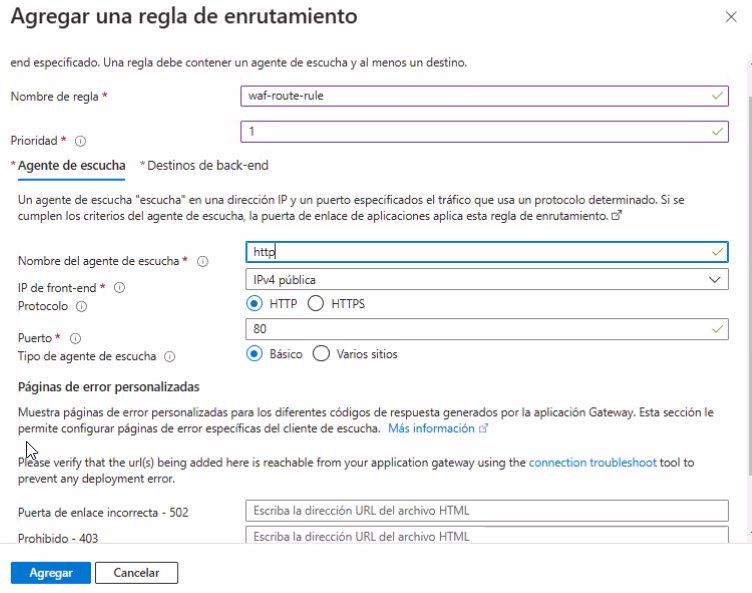

And for the backend targets:

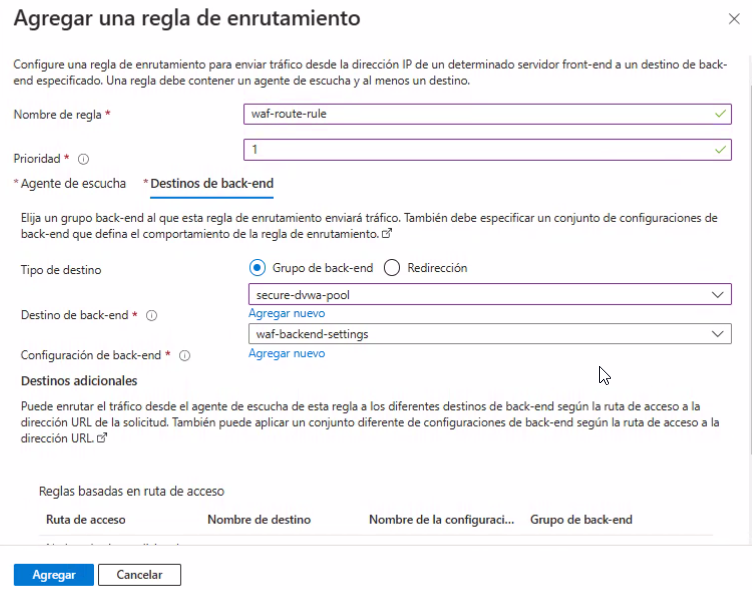

Note that the backend targets need a new backend setting as follows:

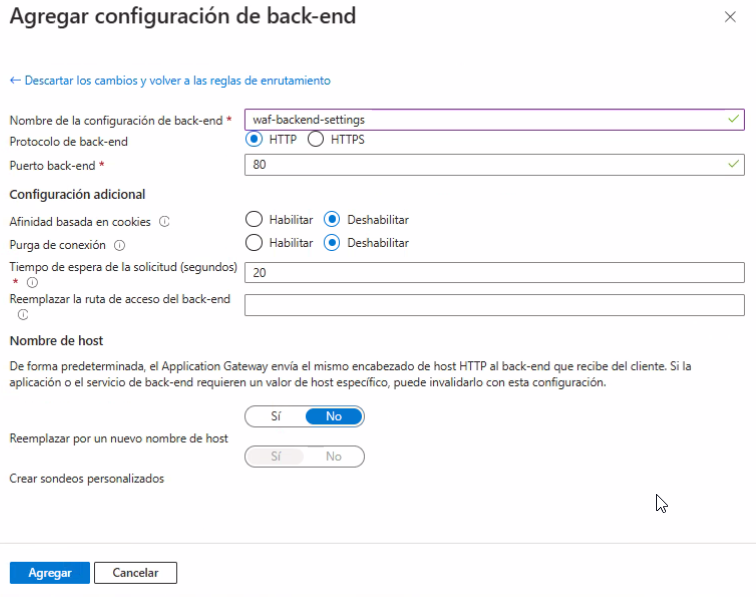

Finally, our Application Gateway will be configured as follows:

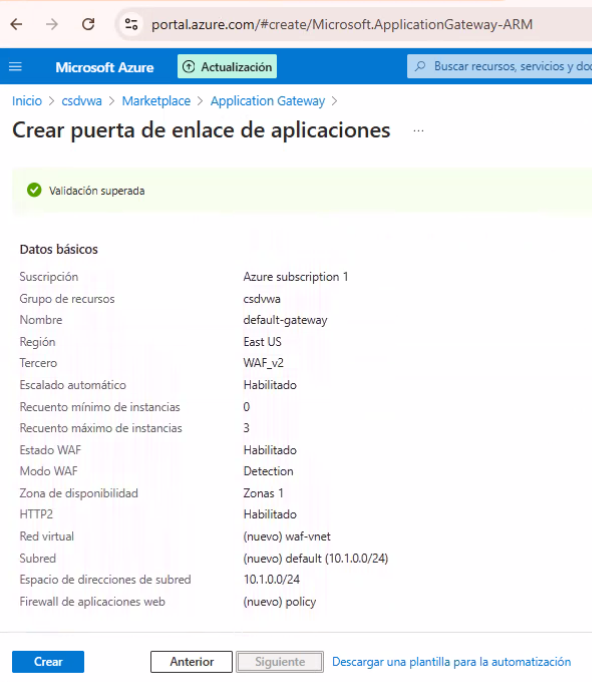

#### Peering

To allow traffic from the waf-vnet into the csdwa-vnet, we need to create a peering under the waf-vnet resources with the following configuration:

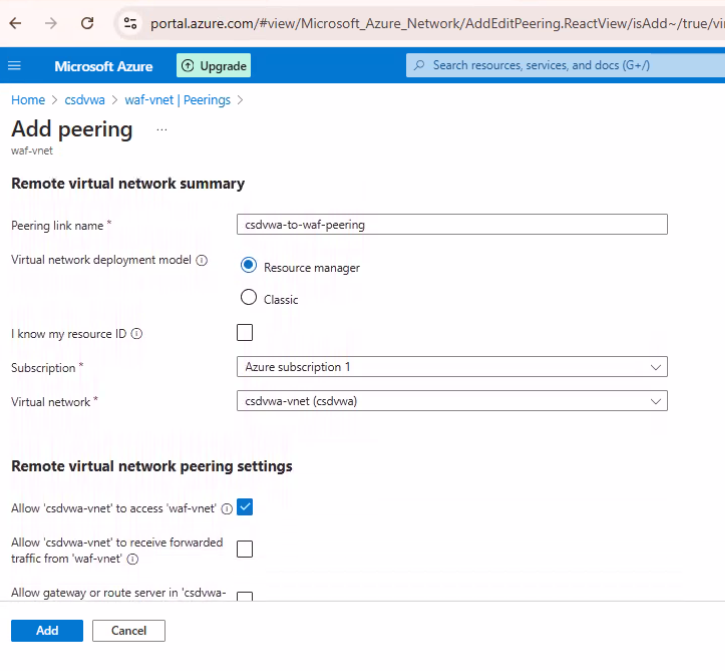

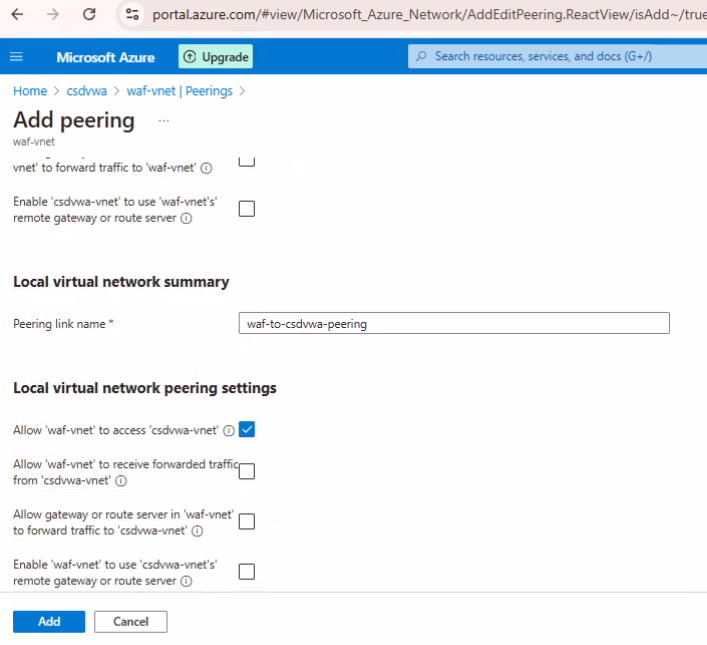

### WAF testing

#### SQL Injection ####

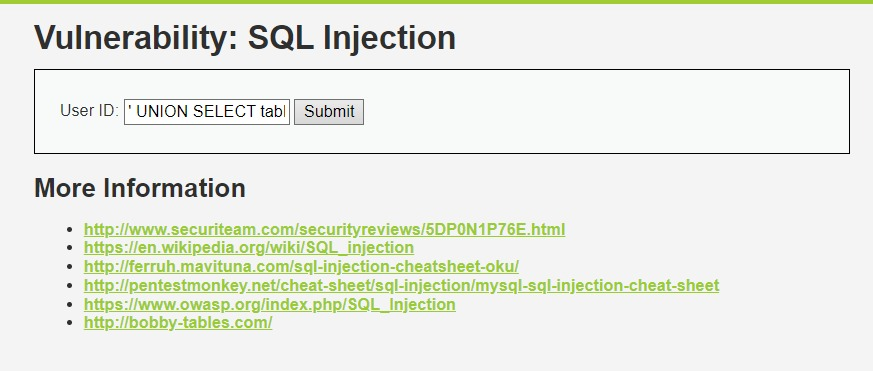

Usually this injection would give us the tables of the database, however.

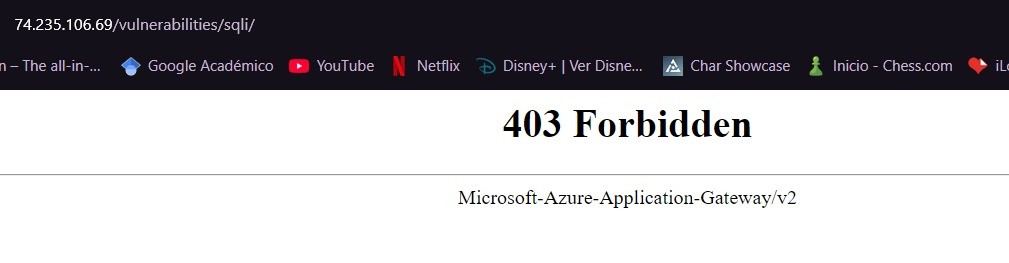

We can see on the url that this belongs to sql injection

#### Brute Force ###

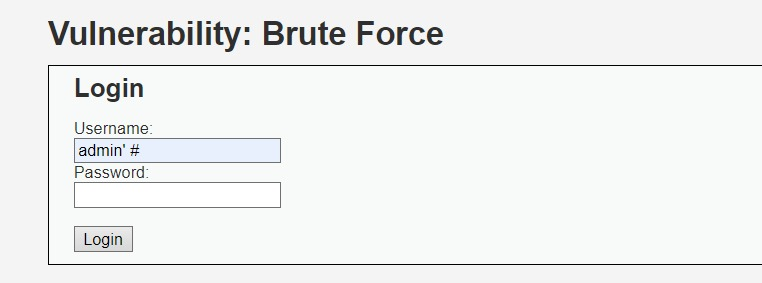

Usually, this lets us bypass the security of the webpage, however

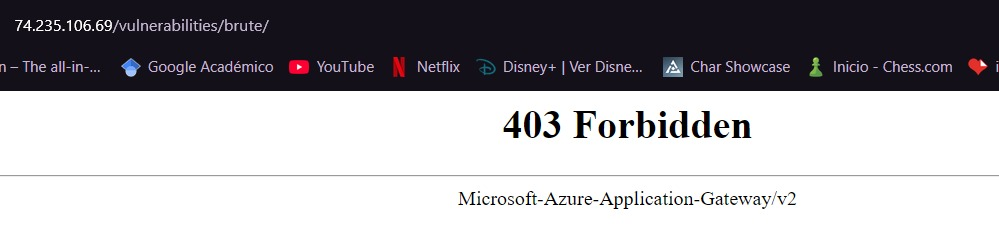

We can see on the url that this belongs to brute force

#### Vulnerability XSS ####

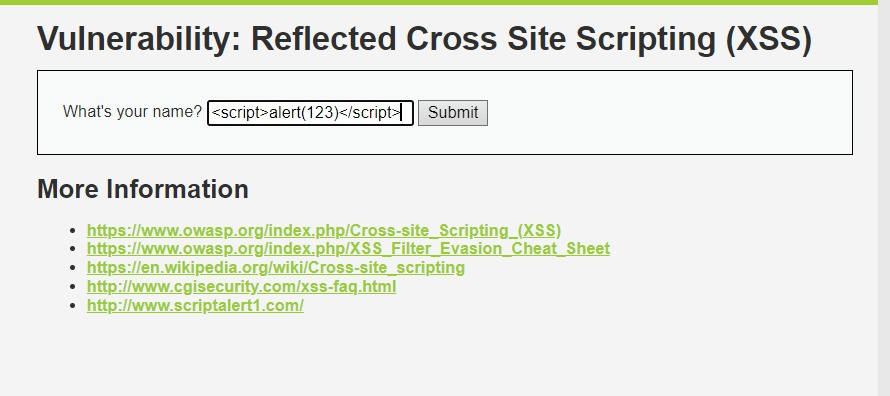

Usually this lets us send an alert, however

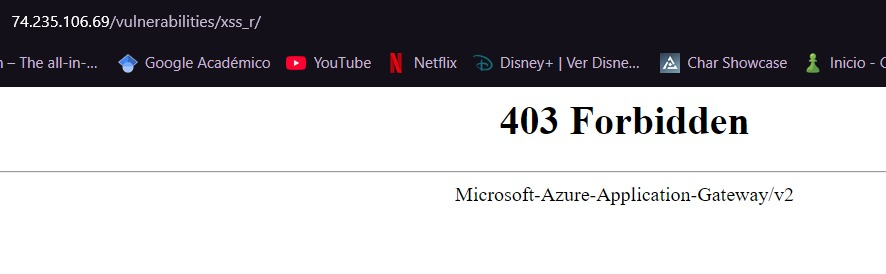

We can see on the url that this belongs to xss


#### Video demonstration ####

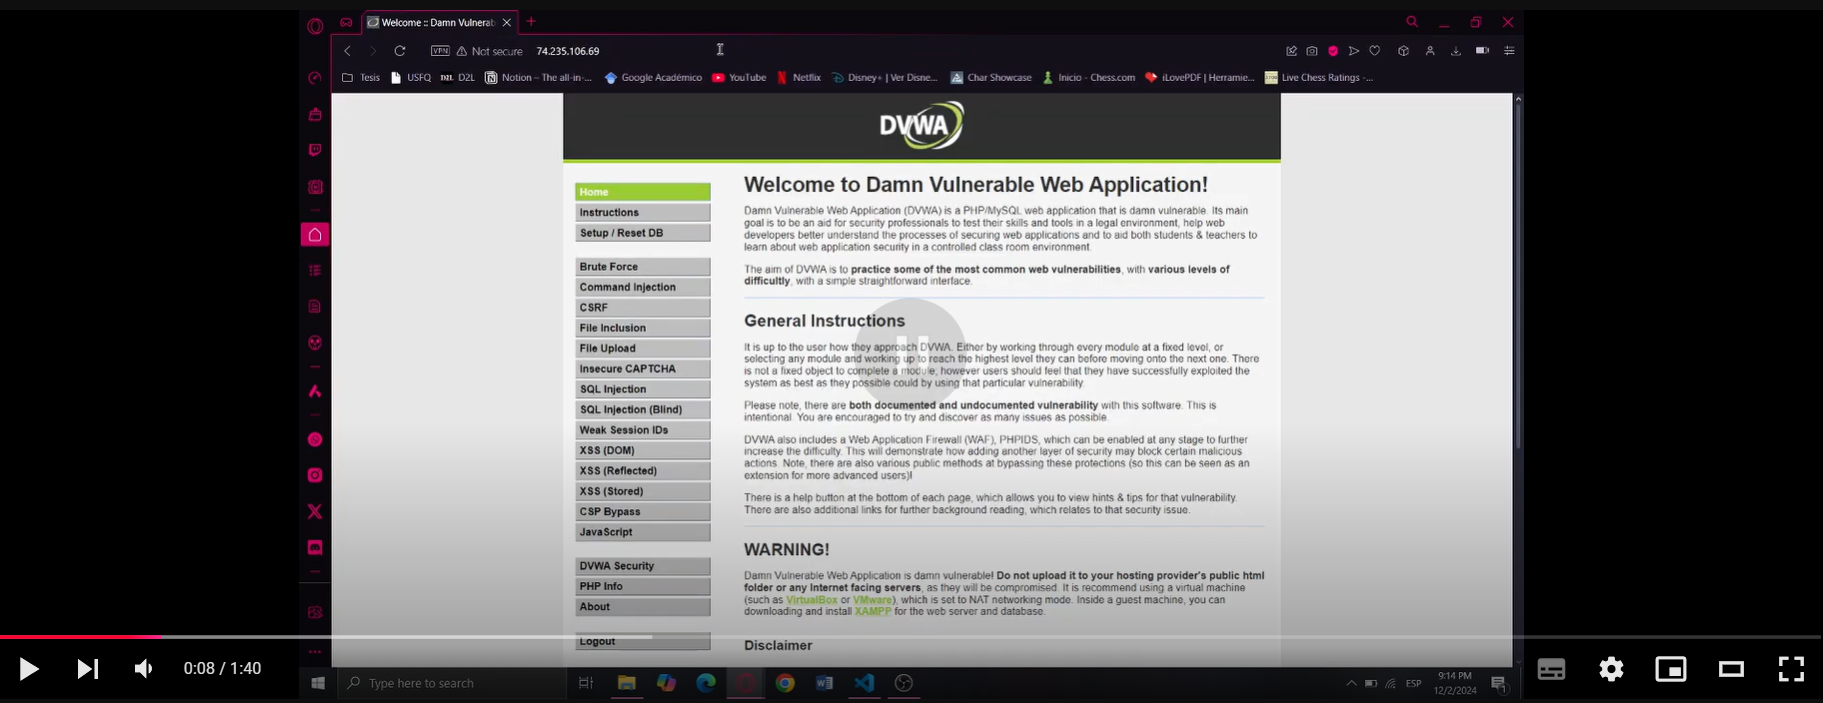

[Video demonstration](https://youtu.be/fE7ezmKbn3U)
